In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import os
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW # Import AdamW
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
import albumentations as A
# NEW: Import ToTensorV2 for augmentations and transformers
from albumentations.pytorch import ToTensorV2
from transformers import SegformerForSemanticSegmentation
import torchmetrics
from tqdm import tqdm

2025-07-16 06:12:51.533105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752646371.717000      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752646371.770865      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# --- 3. DATASET CLASS (UPDATED) ---
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform, size=256):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.size = size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Load as numpy arrays
        img = load_image(img_path, self.size, mask=False)
        mask = load_image(mask_path, self.size, mask=True)

        # Apply transformations
        augmented = self.transform(image=img, mask=mask)
        img_tensor = augmented['image']
        mask_tensor = augmented['mask']

        # CHANGE: Convert mask to long type and remove channel dimension for CrossEntropyLoss
        # The mask should contain class indices (0 or 1).
        # We also convert it to long tensor type.
        mask_tensor = (mask_tensor > 0.5).long() # Binarize and convert to long

        return img_tensor, mask_tensor


In [5]:
# Add Normalize for pretrained model and ToTensorV2
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=1.0),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Create a separate transform for validation/test data without geometric augmentations
val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])


In [6]:
def load_image(path, size, mask=False):
    image = cv2.imread(path)
    if image is None:
        raise FileNotFoundError(f"Cant read image: {path}")
    image = cv2.resize(image, (size, size))
    if mask:
        # Load mask as grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        # Load image as RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Normalization is now handled by Albumentations
    return image

In [7]:
def get_image_mask_paths(root_path):
    image_paths = []
    mask_paths = []
    for folder in os.listdir(root_path):
        folder_path = os.path.join(root_path, folder)
        if not os.path.isdir(folder_path):
            continue
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            is_mask = subfolder.lower() == "mask"
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                if is_mask:
                    mask_paths.append(file_path)
                else:
                    image_paths.append(file_path)
    image_paths.sort()
    mask_paths.sort()
    return image_paths, mask_paths

In [8]:
image_paths, mask_paths = get_image_mask_paths("/kaggle/input/ct-heart-segmentation/data/train")

In [9]:
from sklearn.model_selection import train_test_split
train_val_imgs, test_imgs, train_val_masks, test_masks = train_test_split(
    image_paths, mask_paths, test_size = 0.15, random_state=42
)

In [10]:
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    train_val_imgs, train_val_masks, test_size=0.15, random_state=42
)

In [11]:
train_dataset = SegmentationDataset(train_imgs, train_masks, transform = augmentation, size=256)
val_dataset = SegmentationDataset(val_imgs,val_masks, transform = val_transform, size = 256)
test_dataset = SegmentationDataset(test_imgs, test_masks, transform = val_transform, size = 256)

In [12]:
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader= DataLoader(test_dataset, batch_size=8, shuffle=False)

In [13]:
next(iter(train_loader))[0].shape

torch.Size([8, 3, 256, 256])

In [14]:
next(iter(train_loader))[1].shape

torch.Size([8, 256, 256])

In [15]:
import math

def show_images_and_masks(images, masks, num_samples=8, title="Segmentation: Images and Masks"):
    """
    Display image and mask pairs in a grid.

    Args:
        images (array-like): List or array of images (H, W, C) or (C, H, W).
        masks (array-like): List or array of masks (H,W) OR (H, W,1).
        num_samples (int): Number of samples to display.
        title (str): Figure title.
    """

    num_samples = min(num_samples, len(images), len(masks))
    cols = 2
    pairs_per_row = 4
    rows = math.ceil(num_samples / pairs_per_row)

    fig, axes = plt.subplots(rows, pairs_per_row * cols, figsize=(pairs_per_row * 5, rows * 3.5))
    if rows == 1:
       axes = np.expand_dims(axes,0)

    fig.suptitle(title, fontsize = 18, color='white')
    for i in range(num_samples):
        image = images[i]
        mask = masks[i]

        #if image is torch tensor, convert to numpy
        if hasattr(image, "detach"):
            image = image.detach().cpu().numpy()
        if hasattr(mask, "detach"):
            mask = mask.detach().cpu().numpy()
        # If image is (C,H,W) convert to (H,W,C)
        if image.ndim == 3 and image.shape[0] in [1,3]:
            image =np.transpose(image, (1,2,0))
        # If mask is (1, H, W) or (H, W, 1), squeeze to (H, W)
        if mask.ndim == 3:
            mask = np.squeeze(mask)

        row = i // pairs_per_row
        col_pair = (i % pairs_per_row) * 2
        ax_img = axes[row, col_pair]
        ax_mask = axes[row, col_pair + 1]
        ax_img.imshow(image)
        ax_img.set_title("Image", fontsize = 12)
        ax_img.axis("off")
        ax_mask.imshow(mask, cmap = 'gray')
        ax_mask.set_title("Mask", fontsize=12)
        ax_mask.axis("off")

    #Hide unused axes
    total_slots = rows * pairs_per_row
    for i in range(num_samples, total_slots):
        row = i // pairs_per_row
        col_pair = (i % pairs_per_row) * 2
        axes[row, col_pair].axis("off")
        axes[row, col_pair + 1].axes("off")

    plt.tight_layout()
    plt.subplots_adjust(top = 0.88)
    plt.show()

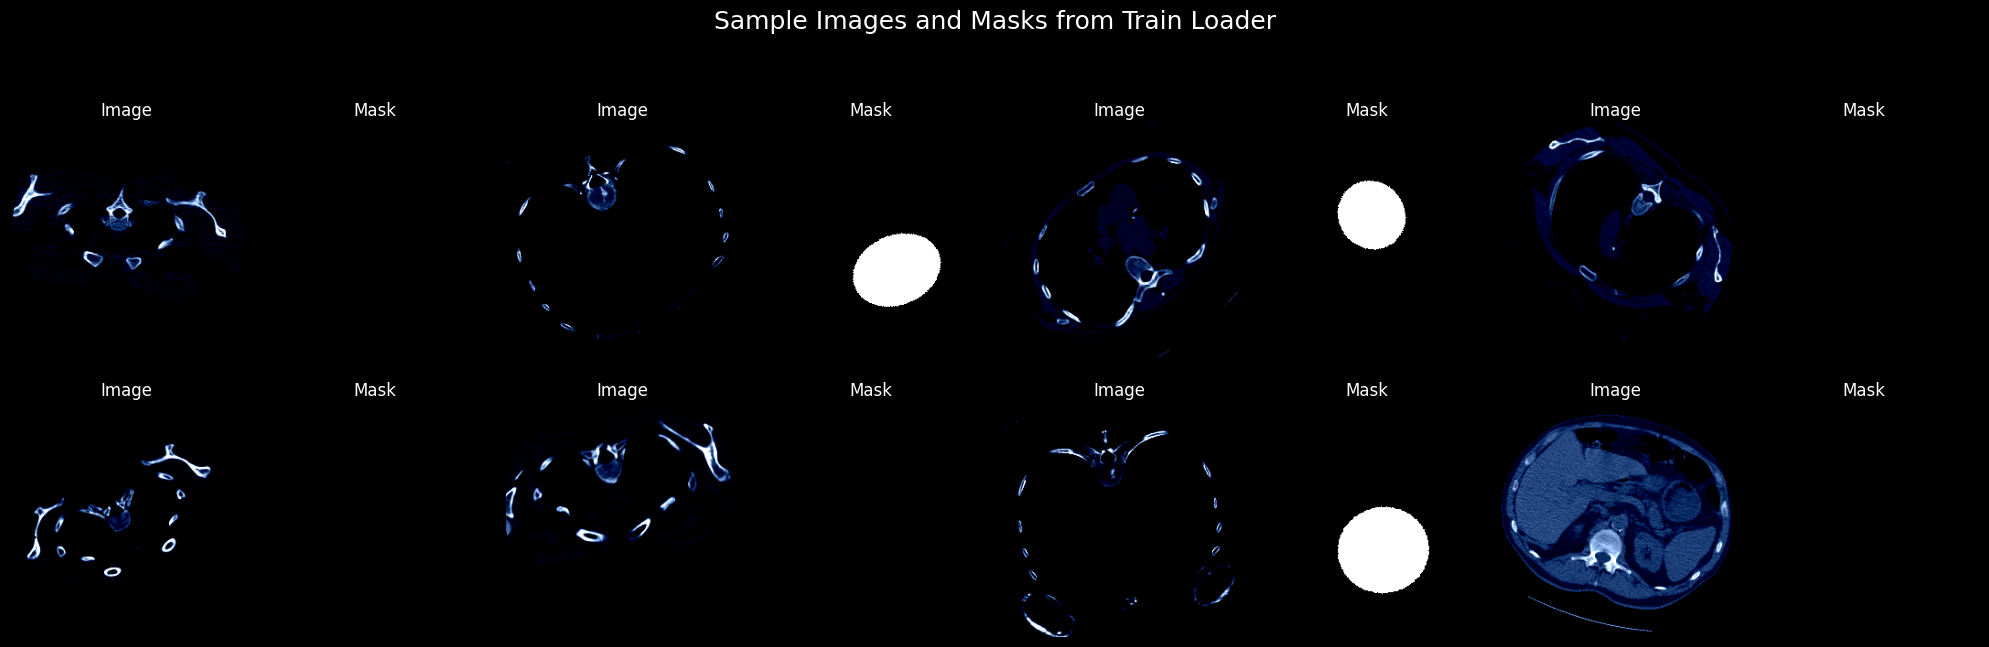

In [16]:
images, masks = next(iter(train_loader))
show_images_and_masks(images, masks, num_samples = 8, title = "Sample Images and Masks from Train Loader")

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
from transformers import SegformerForSemanticSegmentation

# Load pretrained SegFormer model
# num_labels=2 for binary segmentation (background, heart)
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [21]:
# Use AdamW optimizer, recommended for Transformers
optimizer = AdamW(model.parameters(), lr=1e-5)

# Use CrossEntropyLoss for multi-class (2 classes) pixel classification
criterion = nn.CrossEntropyLoss()

# Update metrics for multiclass task
iou_metric = torchmetrics.JaccardIndex(task="multiclass", num_classes=2).to(device)
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)

In [22]:
# --- 6. TRAINING AND VALIDATION LOOP (UPDATED) ---
num_epochs = 20
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 5
save_path = 'best_segformer_model.pth'
history = {'train_loss': [], 'val_loss': [], 'val_iou': [], 'val_acc': []}

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    train_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)

    for images, masks in train_loader_tqdm:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        # Get logits from the model
        outputs = model(pixel_values=images).logits

        # CRITICAL: Upsample logits to match mask size
        upsampled_logits = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)

        # Calculate loss
        loss = criterion(upsampled_logits, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_loader_tqdm.set_postfix(loss=loss.item())

    epoch_train_loss = train_loss / len(train_loader.dataset)
    history['train_loss'].append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    iou_metric.reset()
    accuracy_metric.reset()
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)

    with torch.no_grad():
        for images, masks in val_loader_tqdm:
            images, masks = images.to(device), masks.to(device)

            outputs = model(pixel_values=images).logits
            upsampled_logits = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)

            loss = criterion(upsampled_logits, masks)
            val_loss += loss.item() * images.size(0)

            # Get predictions by taking the argmax along the class dimension
            preds = torch.argmax(upsampled_logits, dim=1)

            iou_metric.update(preds, masks)
            accuracy_metric.update(preds, masks)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_iou = iou_metric.compute()
    epoch_acc = accuracy_metric.compute()

    history['val_loss'].append(epoch_val_loss)
    history['val_iou'].append(epoch_iou.item())
    history['val_acc'].append(epoch_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | IoU: {epoch_iou:.4f} | Acc: {epoch_acc:.4f}")

    # --- Checkpointing and Early Stopping ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model to {save_path}")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break

Epoch 1/20 | Train Loss: 0.5144 | Val Loss: 0.3796 | IoU: 0.6877 | Acc: 0.9609
Saved best model to best_segformer_model.pth


Epoch 2/20 | Train Loss: 0.3200 | Val Loss: 0.2373 | IoU: 0.7950 | Acc: 0.9824
Saved best model to best_segformer_model.pth


Epoch 3/20 | Train Loss: 0.2148 | Val Loss: 0.1763 | IoU: 0.8022 | Acc: 0.9832
Saved best model to best_segformer_model.pth


Epoch 4/20 | Train Loss: 0.1592 | Val Loss: 0.1367 | IoU: 0.8300 | Acc: 0.9867
Saved best model to best_segformer_model.pth


Epoch 5/20 | Train Loss: 0.1249 | Val Loss: 0.1063 | IoU: 0.8572 | Acc: 0.9898
Saved best model to best_segformer_model.pth


Epoch 6/20 | Train Loss: 0.1009 | Val Loss: 0.0879 | IoU: 0.8667 | Acc: 0.9909
Saved best model to best_segformer_model.pth


Epoch 7/20 | Train Loss: 0.0846 | Val Loss: 0.0725 | IoU: 0.8805 | Acc: 0.9922
Saved best model to best_segformer_model.pth


Epoch 8/20 | Train Loss: 0.0721 | Val Loss: 0.0624 | IoU: 0.8847 | Acc: 0.9926
Saved best model to best_segformer_model.pth


Epoch 9/20 | Train Loss: 0.0623 | Val Loss: 0.0557 | IoU: 0.8791 | Acc: 0.9919
Saved best model to best_segformer_model.pth


Epoch 10/20 | Train Loss: 0.0546 | Val Loss: 0.0480 | IoU: 0.8909 | Acc: 0.9930
Saved best model to best_segformer_model.pth


Epoch 11/20 | Train Loss: 0.0489 | Val Loss: 0.0462 | IoU: 0.8730 | Acc: 0.9912
Saved best model to best_segformer_model.pth


Epoch 12/20 | Train Loss: 0.0437 | Val Loss: 0.0395 | IoU: 0.8931 | Acc: 0.9932
Saved best model to best_segformer_model.pth


Epoch 13/20 | Train Loss: 0.0396 | Val Loss: 0.0373 | IoU: 0.8854 | Acc: 0.9924
Saved best model to best_segformer_model.pth


Epoch 14/20 | Train Loss: 0.0357 | Val Loss: 0.0320 | IoU: 0.8953 | Acc: 0.9934
Saved best model to best_segformer_model.pth


Epoch 15/20 | Train Loss: 0.0336 | Val Loss: 0.0304 | IoU: 0.8961 | Acc: 0.9934
Saved best model to best_segformer_model.pth


Epoch 16/20 | Train Loss: 0.0309 | Val Loss: 0.0284 | IoU: 0.8967 | Acc: 0.9935
Saved best model to best_segformer_model.pth


Epoch 17/20 | Train Loss: 0.0283 | Val Loss: 0.0275 | IoU: 0.8966 | Acc: 0.9933
Saved best model to best_segformer_model.pth


Epoch 18/20 | Train Loss: 0.0264 | Val Loss: 0.0267 | IoU: 0.8944 | Acc: 0.9931
Saved best model to best_segformer_model.pth


Epoch 19/20 | Train Loss: 0.0249 | Val Loss: 0.0252 | IoU: 0.8955 | Acc: 0.9932
Saved best model to best_segformer_model.pth


Epoch 20/20 | Train Loss: 0.0235 | Val Loss: 0.0236 | IoU: 0.8970 | Acc: 0.9933
Saved best model to best_segformer_model.pth


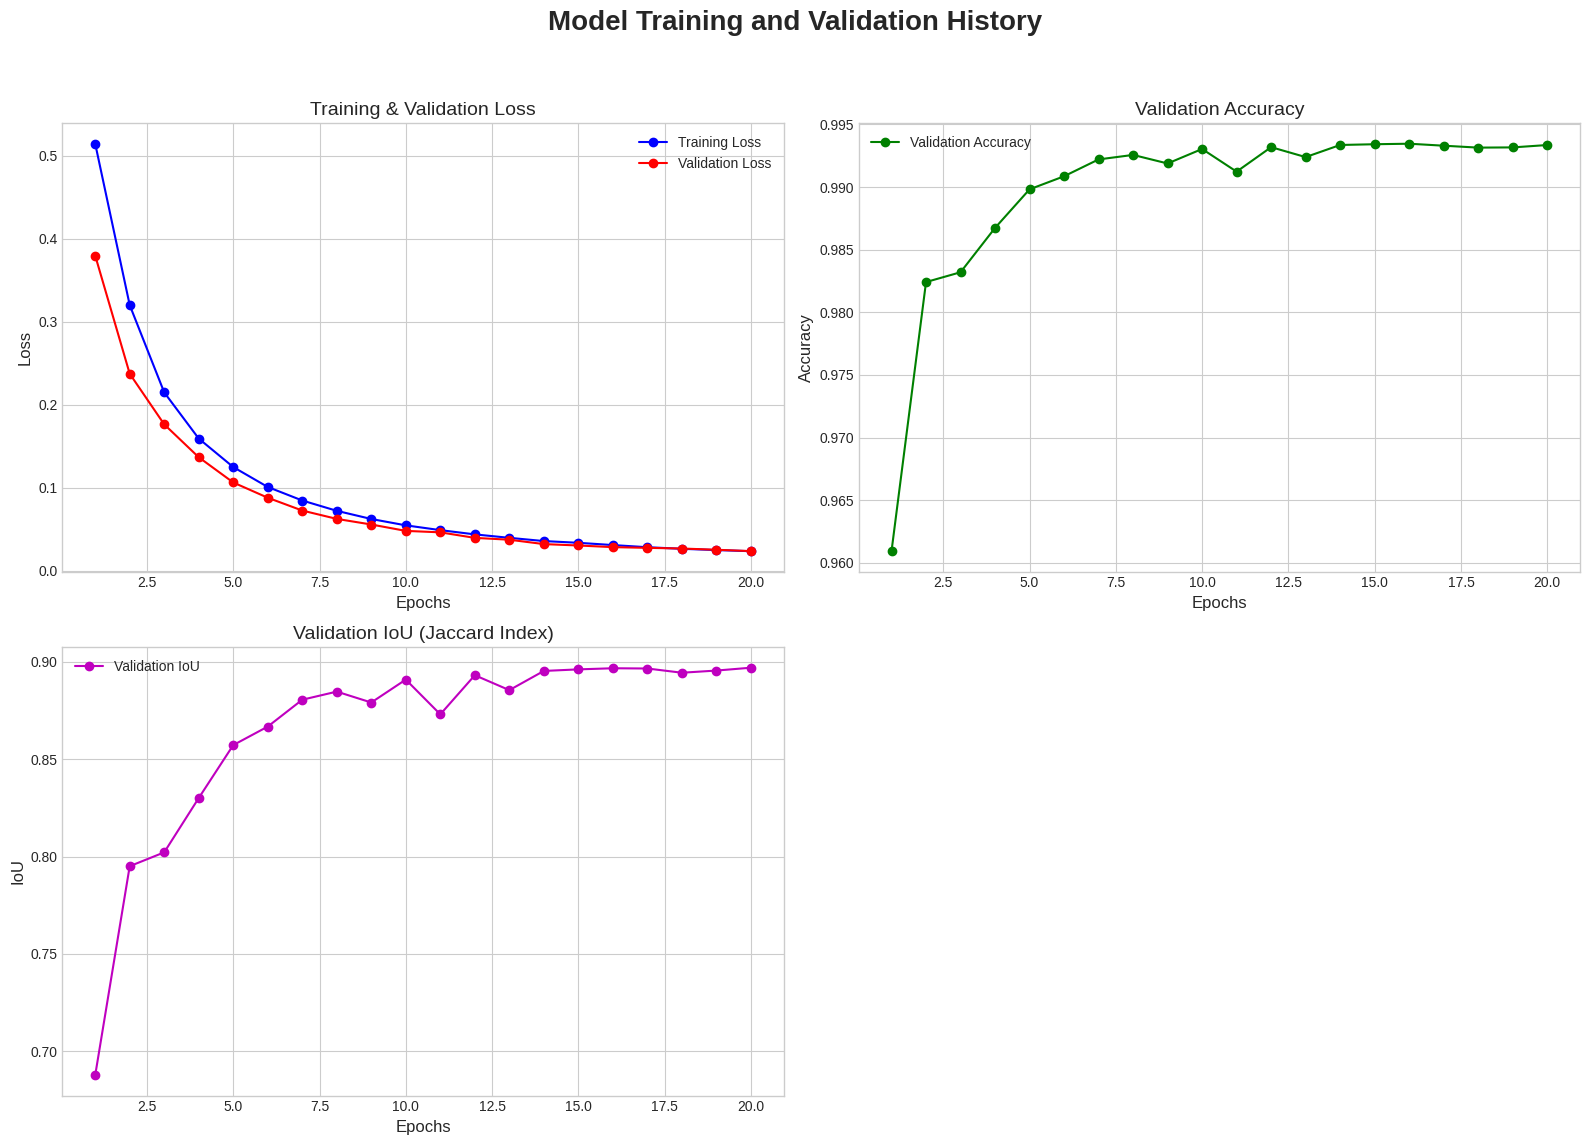

In [33]:
num_epochs_trained = len(history['train_loss'])
epoch_range = range(1, num_epochs_trained + 1)

# Create a figure with a 2x2 grid of subplots
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Training and Validation History', fontsize=20, weight='bold')

# --- Plot 1: Training & Validation Loss ---
# This plot is crucial for identifying overfitting. If the training loss
# continues to decrease while validation loss increases, the model is overfitting.
axs[0, 0].plot(epoch_range, history['train_loss'], 'b-o', label='Training Loss')
axs[0, 0].plot(epoch_range, history['val_loss'], 'r-o', label='Validation Loss')
axs[0, 0].set_title('Training & Validation Loss', fontsize=14)
axs[0, 0].set_xlabel('Epochs', fontsize=12)
axs[0, 0].set_ylabel('Loss', fontsize=12)
axs[0, 0].legend()

# --- Plot 2: Validation Accuracy ---
# Shows the percentage of correctly classified pixels in the validation set.
# You want to see this value increase and then plateau.
axs[0, 1].plot(epoch_range, history['val_acc'], 'g-o', label='Validation Accuracy')
axs[0, 1].set_title('Validation Accuracy', fontsize=14)
axs[0, 1].set_xlabel('Epochs', fontsize=12)
axs[0, 1].set_ylabel('Accuracy', fontsize=12)
axs[0, 1].legend()

# --- Plot 3: Validation IoU (Jaccard Index) ---
# IoU is a key metric for segmentation. It measures the overlap between
# the predicted mask and the ground truth mask. Higher is better.
axs[1, 0].plot(epoch_range, history['val_iou'], 'm-o', label='Validation IoU')
axs[1, 0].set_title('Validation IoU (Jaccard Index)', fontsize=14)
axs[1, 0].set_xlabel('Epochs', fontsize=12)
axs[1, 0].set_ylabel('IoU', fontsize=12)
axs[1, 0].legend()

# --- Hide the empty subplot ---
axs[1, 1].axis('off')

# Adjust layout to prevent titles from overlapping and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [23]:
# --- 1. MODEL LOADING (CHANGED) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path = 'best_segformer_model.pth'

In [24]:
# First, create the model architecture, same as in the training script
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=2,
    ignore_mismatched_sizes=True
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Second, load the saved weights (state_dict) into the model
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)
model.eval() # Set the model to evaluation mode

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [26]:
def unnormalize_image(tensor):
    """Reverses the ImageNet normalization for visualization."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # .permute(1, 2, 0) changes from (C, H, W) to (H, W, C) for numpy
    unnormalized = tensor.cpu().permute(1, 2, 0).numpy()
    unnormalized = (unnormalized * std + mean).clip(0, 1) # Reverse normalization and clip
    return unnormalized

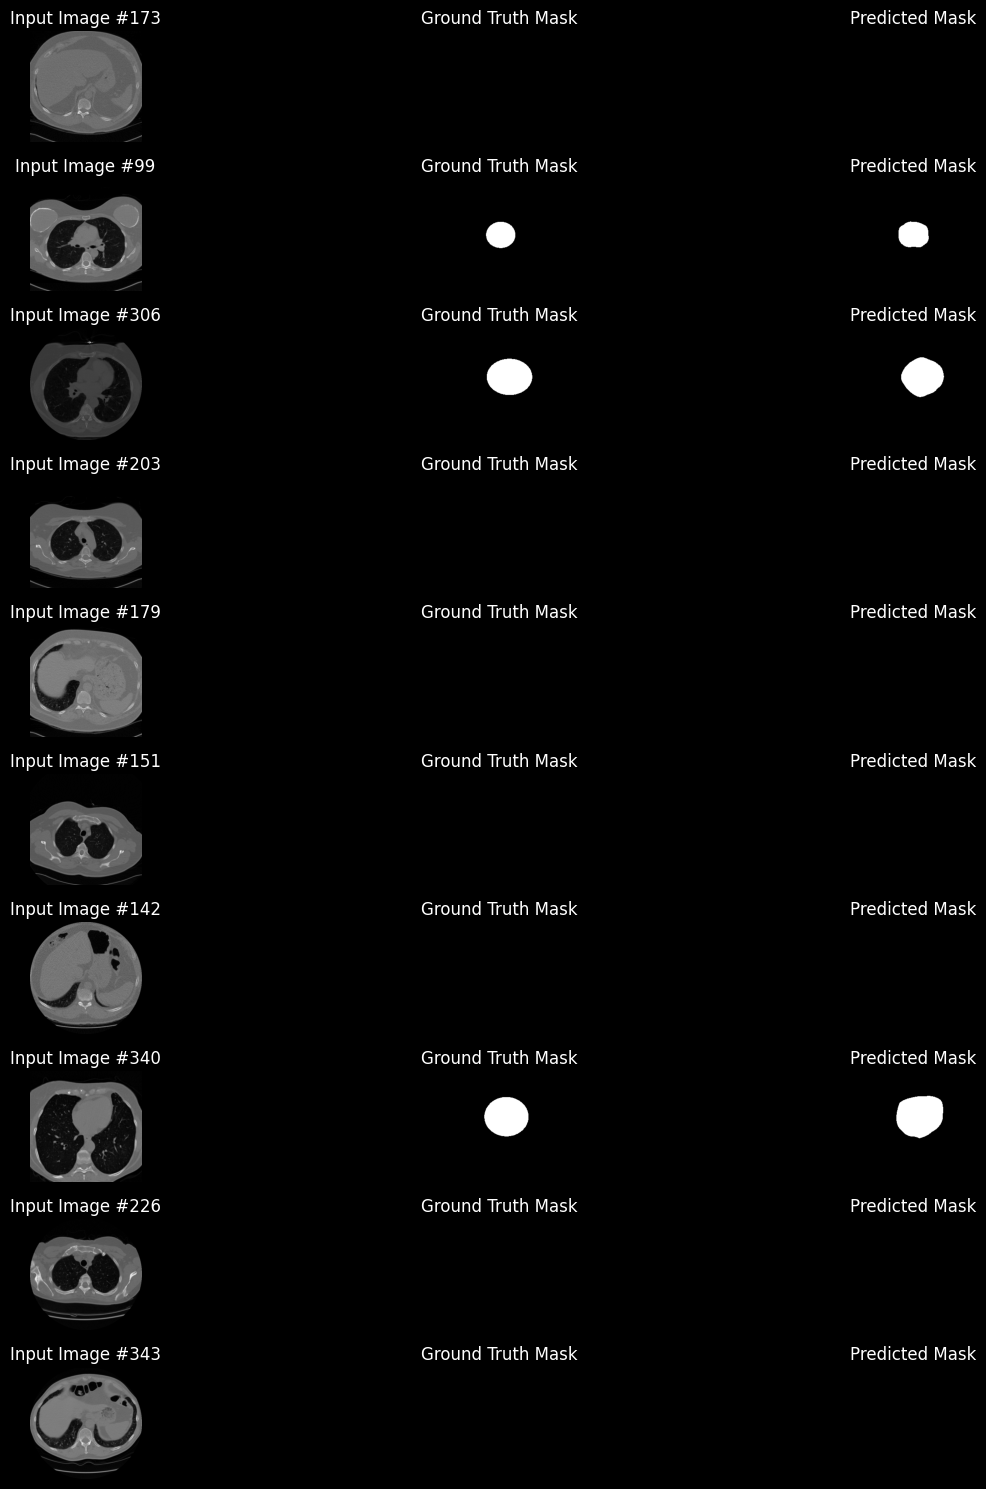

In [29]:
import random
# --- 3. VISUALIZATION LOOP (UPDATED) ---
# Select 3 random samples from the test dataset
random_indices = random.sample(range(len(test_dataset)), 10)

with torch.no_grad():
    fig, axs = plt.subplots(10, 3, figsize=(15, 15))

    for i, idx in enumerate(random_indices):
        # Get image and mask from your test dataset
        image, mask = test_dataset[idx]
        
        # Add a batch dimension (B, C, H, W) and send to device
        image_batch = image.unsqueeze(0).to(device)  

        # --- Forward pass (CHANGED) ---
        # Pass the image using the 'pixel_values' keyword argument
        outputs = model(pixel_values=image_batch).logits
        
        # Upsample the output to match the mask size
        upsampled_output = F.interpolate(outputs, size=mask.shape[-2:], mode='bilinear', align_corners=False)
        
        # Get the final prediction by taking the argmax
        pred_mask = torch.argmax(upsampled_output, dim=1).squeeze(0) # Shape: (H, W)

        # --- Prepare images for plotting ---
        # Un-normalize the input image for correct display
        input_image_display = unnormalize_image(image)

        # Plot Input Image
        axs[i, 0].imshow(input_image_display)
        axs[i, 0].set_title(f"Input Image #{idx}")
        axs[i, 0].axis("off")

        # Plot Ground Truth
        axs[i, 1].imshow(mask.cpu().numpy(), cmap='gray')
        axs[i, 1].set_title("Ground Truth Mask")
        axs[i, 1].axis("off")

        # Plot Predicted Mask
        axs[i, 2].imshow(pred_mask.cpu().numpy(), cmap='gray')
        axs[i, 2].set_title("Predicted Mask")
        axs[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("--- Metrics for 3 Random Samples ---")
random_indices = random.sample(range(len(test_dataset)), 3)

with torch.no_grad():
    for i, idx in enumerate(random_indices):
        # Get image and mask from your dataset
        image, mask = test_dataset[idx]

        # Add a batch dimension to the image and send to device
        image = image.unsqueeze(0).to(device)

        # Forward pass using the 'pixel_values' keyword
        outputs = model(pixel_values=image).logits
        
        # Upsample logits to match mask size
        upsampled_logits = F.interpolate(outputs, size=mask.shape[-2:], mode='bilinear', align_corners=False)

        # Get prediction by taking the argmax along the class dimension
        preds = torch.argmax(upsampled_logits, dim=1)  # Shape: (1, H, W)

        # Flatten the ground truth mask and predictions for scikit-learn
        y_true = mask.cpu().numpy().flatten()
        y_pred = preds.cpu().numpy().flatten()

        # Calculate metrics for this single sample
        accuracy = accuracy_score(y_true, y_pred)
        # For binary (0/1) case, pos_label=1 specifies the class to report on
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

        print(f"\nSample Index {idx} Metrics:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision (for Heart): {precision:.4f}")
        print(f"  Recall (for Heart): {recall:.4f}")
        print(f"  F1 Score (for Heart): {f1:.4f}")

--- Metrics for 3 Random Samples ---

Sample Index 378 Metrics:
  Accuracy: 1.0000
  Precision (for Heart): 0.0000
  Recall (for Heart): 0.0000
  F1 Score (for Heart): 0.0000

Sample Index 292 Metrics:
  Accuracy: 1.0000
  Precision (for Heart): 0.0000
  Recall (for Heart): 0.0000
  F1 Score (for Heart): 0.0000

Sample Index 243 Metrics:
  Accuracy: 0.9886
  Precision (for Heart): 0.9412
  Recall (for Heart): 0.9441
  F1 Score (for Heart): 0.9427


In [32]:
print("\n--- Calculating Overall Metrics for the Entire Test Set ---")

all_preds = []
all_targets = []

# Use the test_loader for efficient, batched processing
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Evaluating Test Set"):
        # Send data to the device
        images = images.to(device)
        
        # Forward pass
        outputs = model(pixel_values=images).logits
        
        # Upsample logits
        upsampled_logits = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)

        # Get predictions
        preds = torch.argmax(upsampled_logits, dim=1) # Shape: (Batch, H, W)

        # Extend the lists with flattened results from the current batch
        all_preds.extend(preds.cpu().numpy().flatten().tolist())
        all_targets.extend(masks.cpu().numpy().flatten().tolist())

# Calculate overall metrics on all collected predictions and targets
overall_accuracy = accuracy_score(all_targets, all_preds)
overall_precision = precision_score(all_targets, all_preds, pos_label=1, zero_division=0)
overall_recall = recall_score(all_targets, all_preds, pos_label=1, zero_division=0)
overall_f1 = f1_score(all_targets, all_preds, pos_label=1, zero_division=0)

print("\nOverall Test Set Metrics:")
print(f"  Accuracy: {overall_accuracy:.4f}")
print(f"  Precision (for Heart): {overall_precision:.4f}")
print(f"  Recall (for Heart): {overall_recall:.4f}")
print(f"  F1 Score (for Heart): {overall_f1:.4f}")


--- Calculating Overall Metrics for the Entire Test Set ---


Evaluating Test Set: 100%|██████████| 48/48 [00:11<00:00,  4.02it/s]



Overall Test Set Metrics:
  Accuracy: 0.9935
  Precision (for Heart): 0.9001
  Recall (for Heart): 0.8996
  F1 Score (for Heart): 0.8999
